# Simple Attention

In [1]:
import torch
inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your     (x^1)
     [0.55, 0.87, 0.66], # journey  (x^2)
     [0.57, 0.85, 0.64], # starts   (x^3)
     [0.22, 0.58, 0.33], # with     (x^4)
     [0.77, 0.25, 0.10], # one      (x^5)
     [0.05, 0.80, 0.55]] # step     (x^6)
)

### Attention weight is simply self multiplication

`[Context_szie x Dimension] * [Dimension * Context_size]`
* Row i: attentions regarding ith input token
* Col j: weight towards the jth input token

In [1]:
attention_weights = torch.softmax(inputs @ inputs.T, dim=-1)
attention_weights

NameError: name 'torch' is not defined

In [ ]:
attention_weights.sum(-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

### Attention embedding

`[Context size * Context size] * [Context size * Dimension]`

Each input's attention weights (rows in first matrix) is dot product with each of the dimensions
* Row i: input i
* Col j: j dimension of the attention embedding

In [ ]:
attention_embedding = attention_weights @ inputs 
attention_embedding

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])

In [ ]:
inputs

tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])

### Self Attention

In [ ]:
import tiktoken
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
tokenizer = tiktoken.get_encoding('gpt2')
token_ids = tokenizer.encode(raw_text)

In [ ]:
EMBEDDING_DIM = 4
CONTEXT_SIZE = 6
embedding_layer = torch.nn.Embedding(tokenizer.n_vocab, EMBEDDING_DIM)
inputs = embedding_layer(torch.tensor(token_ids[:CONTEXT_SIZE], requires_grad=False))
inputs = inputs.abs() # reduce value variance
inputs[0][:10]

tensor([0.7743, 1.6062, 0.3699, 1.1433], grad_fn=<SliceBackward0>)

In [ ]:
in_dim = inputs.shape[1]
out_dim = EMBEDDING_DIM
print(f"in_dim={in_dim}")

in_dim=4


In [ ]:
W_q = torch.nn.Parameter(torch.rand(in_dim, out_dim), requires_grad=False)
W_k = torch.nn.Parameter(torch.rand(in_dim, out_dim), requires_grad=False)
W_v = torch.nn.Parameter(torch.rand(in_dim, out_dim), requires_grad=False)
W_k[0][:10]

tensor([0.0628, 0.8390, 0.7080, 0.3304])

In [ ]:
query = inputs @ W_q
key = inputs @ W_k
value = inputs @ W_v
print(f"query={query.shape}\nkey={key.shape}\nvalue={value.shape}")

query=torch.Size([6, 4])
key=torch.Size([6, 4])
value=torch.Size([6, 4])


In [ ]:
attention_score = query @ key.T
attention_score[0][:10]

tensor([18.4146, 24.3641, 24.9585, 10.2176, 13.0545, 37.7691],
       grad_fn=<SliceBackward0>)

In [ ]:
print(f"scale = {out_dim ** 0.5}")
(attention_score / out_dim ** 0.5)[0][:10]

scale = 2.0


tensor([ 9.2073, 12.1821, 12.4793,  5.1088,  6.5272, 18.8845],
       grad_fn=<SliceBackward0>)

### Softmax without scaling

In [ ]:
scores_unscaled = torch.softmax(attention_score, dim=-1)
scores_unscaled[0][:10]

tensor([3.9307e-09, 1.5077e-06, 2.7319e-06, 1.0828e-12, 1.8475e-11, 1.0000e+00],
       grad_fn=<SliceBackward0>)

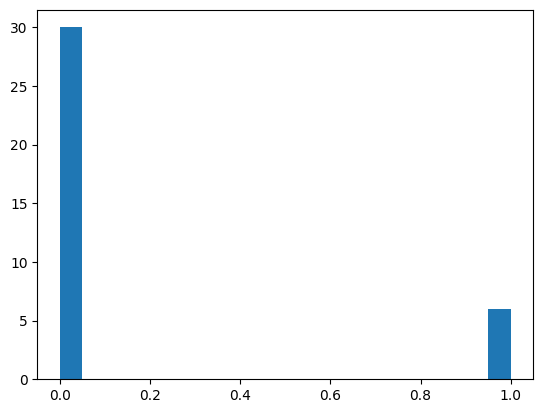

In [ ]:
import numpy
import matplotlib.pyplot as plt
all_data = scores_unscaled.detach().numpy().flatten()
p=plt.hist(all_data, bins=20, range=[0,1])

### Softmax with scaling

In [ ]:
scores_scaled = torch.softmax(attention_score / out_dim**0.5 , dim=-1)
scores_scaled[0][:10]

tensor([6.2511e-05, 1.2243e-03, 1.6480e-03, 1.0375e-06, 4.2857e-06, 9.9706e-01],
       grad_fn=<SliceBackward0>)

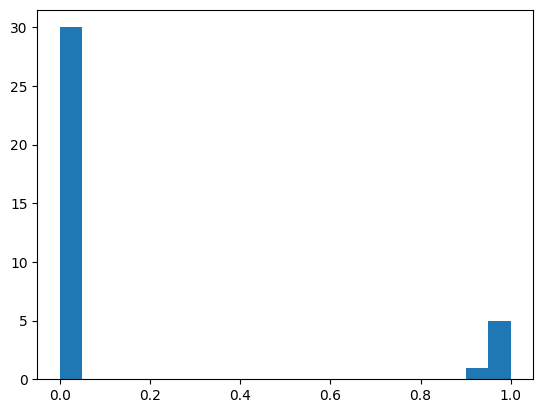

In [ ]:
all_data = scores_scaled.detach().numpy().flatten()
p=plt.hist(all_data, bins=20)

In [ ]:
inputs

tensor([[0.7743, 1.6062, 0.3699, 1.1433],
        [0.0638, 1.0122, 2.0194, 1.5732],
        [0.4044, 0.7246, 1.1274, 2.4576],
        [0.6338, 0.0303, 0.7836, 0.5576],
        [0.7420, 0.4649, 1.3946, 0.0973],
        [2.4284, 0.8393, 3.1497, 1.2533]], grad_fn=<AbsBackward0>)

In [ ]:
from self_attention_v1 import SelfAttentionV1
from self_attention_v2 import SelfAttentionV2
torch.manual_seed(789)

self_attention_v1 = SelfAttentionV1(inputs.shape[1], 2)
self_attention_v2 = SelfAttentionV2(inputs.shape[1], 2)

In [ ]:
print(self_attention_v1.forward(inputs))
print(self_attention_v2.forward(inputs))

tensor([[3.9339, 2.7046],
        [3.9286, 2.7012],
        [3.9342, 2.7048],
        [3.6845, 2.5471],
        [3.8317, 2.6399],
        [3.9379, 2.7072]], grad_fn=<MmBackward0>)
tensor([[-0.2866,  0.6251],
        [-0.2484,  0.6460],
        [-0.2454,  0.6479],
        [-0.2617,  0.6402],
        [-0.2640,  0.6386],
        [-0.2056,  0.6569]], grad_fn=<MmBackward0>)


In [ ]:
self_attention_v1.W_key.data

tensor([[0.7051, 0.6848],
        [0.2748, 0.0579],
        [0.7187, 0.3775],
        [0.3301, 0.9496]])

In [ ]:
self_attention_v1.W_query.data = self_attention_v2.W_query.weight.T
self_attention_v1.W_key.data = self_attention_v2.W_key.weight.T
self_attention_v1.W_value.data = self_attention_v2.W_value.weight.T

In [ ]:
print(self_attention_v1.forward(inputs))
print(self_attention_v2.forward(inputs))

tensor([[-0.2866,  0.6251],
        [-0.2484,  0.6460],
        [-0.2454,  0.6479],
        [-0.2617,  0.6402],
        [-0.2640,  0.6386],
        [-0.2056,  0.6569]], grad_fn=<MmBackward0>)
tensor([[-0.2866,  0.6251],
        [-0.2484,  0.6460],
        [-0.2454,  0.6479],
        [-0.2617,  0.6402],
        [-0.2640,  0.6386],
        [-0.2056,  0.6569]], grad_fn=<MmBackward0>)


In [ ]:
context_length = inputs.shape[0]
torch.triu(torch.ones(context_length, context_length), diagonal=1).bool()


tensor([[False,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True],
        [False, False, False, False,  True,  True],
        [False, False, False, False, False,  True],
        [False, False, False, False, False, False]])

In [ ]:
dropout = torch.nn.Dropout(0.5)
dropout(torch.ones(6,6))

tensor([[0., 2., 0., 2., 2., 0.],
        [0., 0., 0., 0., 0., 2.],
        [2., 2., 2., 0., 2., 2.],
        [0., 2., 0., 2., 2., 0.],
        [2., 0., 0., 2., 0., 2.],
        [2., 0., 0., 2., 0., 2.]])

# Attention with batch

In [2]:
torch.manual_seed(123)
batch = torch.stack((inputs, inputs))
batch.shape

torch.Size([2, 6, 3])

In [3]:
batch_size, context_size, d_in = batch.shape
W_queries = torch.nn.Linear(d_in, 2, False)
W_keys = torch.nn.Linear(d_in, 2, False)
W_values = torch.nn.Linear(d_in, 2, False) 

In [ ]:
queries = W_queries(batch)
keys = W_keys(batch)
values = W_values(batch)
queries.shape

torch.Size([2, 6, 2])

In [ ]:
keys

tensor([[[ 0.2647, -0.9961],
         [ 0.1303, -0.8595],
         [ 0.2879, -0.8399],
         [-0.2338, -0.4768],
         [-0.3686, -0.7215],
         [-0.9246, -1.9865]],

        [[ 0.2647, -0.9961],
         [ 0.1303, -0.8595],
         [ 0.2879, -0.8399],
         [-0.2338, -0.4768],
         [-0.3686, -0.7215],
         [-0.9246, -1.9865]]], grad_fn=<UnsafeViewBackward0>)

In [ ]:
keys.mT.shape

torch.Size([2, 2, 6])

In [ ]:
attn_scores = queries @ keys.mT
attn_scores

tensor([[[0.3268, 0.2827, 0.2751, 0.1591, 0.2409, 0.6627],
         [0.9583, 0.8465, 0.7950, 0.5312, 0.8068, 2.2032],
         [1.3182, 1.1263, 1.1189, 0.5903, 0.8915, 2.4649],
         [0.7046, 0.6293, 0.5800, 0.4159, 0.6326, 1.7221],
         [0.5637, 0.5326, 0.4448, 0.4398, 0.6726, 1.8091],
         [2.0887, 1.9029, 1.6948, 1.3700, 2.0884, 5.6573]],

        [[0.3268, 0.2827, 0.2751, 0.1591, 0.2409, 0.6627],
         [0.9583, 0.8465, 0.7950, 0.5312, 0.8068, 2.2032],
         [1.3182, 1.1263, 1.1189, 0.5903, 0.8915, 2.4649],
         [0.7046, 0.6293, 0.5800, 0.4159, 0.6326, 1.7221],
         [0.5637, 0.5326, 0.4448, 0.4398, 0.6726, 1.8091],
         [2.0887, 1.9029, 1.6948, 1.3700, 2.0884, 5.6573]]],
       grad_fn=<UnsafeViewBackward0>)

In [ ]:
mask = torch.triu(torch.ones(context_size, context_size), diagonal=1)
mask.bool()

tensor([[False,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True],
        [False, False, False, False,  True,  True],
        [False, False, False, False, False,  True],
        [False, False, False, False, False, False]])

In [ ]:
attn_scores.masked_fill_(mask.bool(), -torch.inf)

tensor([[[0.3268,   -inf,   -inf,   -inf,   -inf,   -inf],
         [0.9583, 0.8465,   -inf,   -inf,   -inf,   -inf],
         [1.3182, 1.1263, 1.1189,   -inf,   -inf,   -inf],
         [0.7046, 0.6293, 0.5800, 0.4159,   -inf,   -inf],
         [0.5637, 0.5326, 0.4448, 0.4398, 0.6726,   -inf],
         [2.0887, 1.9029, 1.6948, 1.3700, 2.0884, 5.6573]],

        [[0.3268,   -inf,   -inf,   -inf,   -inf,   -inf],
         [0.9583, 0.8465,   -inf,   -inf,   -inf,   -inf],
         [1.3182, 1.1263, 1.1189,   -inf,   -inf,   -inf],
         [0.7046, 0.6293, 0.5800, 0.4159,   -inf,   -inf],
         [0.5637, 0.5326, 0.4448, 0.4398, 0.6726,   -inf],
         [2.0887, 1.9029, 1.6948, 1.3700, 2.0884, 5.6573]]],
       grad_fn=<MaskedFillBackward0>)

In [ ]:
attn_weights = torch.softmax( attn_scores, dim=-1)
attn_weights

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5279, 0.4721, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3781, 0.3121, 0.3098, 0.0000, 0.0000, 0.0000],
         [0.2809, 0.2606, 0.2480, 0.2105, 0.0000, 0.0000],
         [0.2059, 0.1996, 0.1829, 0.1819, 0.2296, 0.0000],
         [0.0253, 0.0210, 0.0171, 0.0124, 0.0253, 0.8988]],

        [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5279, 0.4721, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3781, 0.3121, 0.3098, 0.0000, 0.0000, 0.0000],
         [0.2809, 0.2606, 0.2480, 0.2105, 0.0000, 0.0000],
         [0.2059, 0.1996, 0.1829, 0.1819, 0.2296, 0.0000],
         [0.0253, 0.0210, 0.0171, 0.0124, 0.0253, 0.8988]]],
       grad_fn=<SoftmaxBackward0>)

In [ ]:
attn_weights @ values

tensor([[[ 0.3704,  1.0257],
         [ 0.3473,  1.0855],
         [ 0.3471,  1.2279],
         [ 0.2238,  1.1000],
         [ 0.0965,  0.9593],
         [-0.7265,  1.8707]],

        [[ 0.3704,  1.0257],
         [ 0.3473,  1.0855],
         [ 0.3471,  1.2279],
         [ 0.2238,  1.1000],
         [ 0.0965,  0.9593],
         [-0.7265,  1.8707]]], grad_fn=<UnsafeViewBackward0>)

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from causal_attention import CausalAttention
torch.manual_seed(123)
causal_attention = CausalAttention(
    batch.shape[-1],
    2,
    batch.shape[-2],
    dropout=0.5
)
causal_attention.forward(batch)

tensor([[[ 0.0000,  0.0000],
         [ 0.3035,  1.0879],
         [ 0.2007,  0.7192],
         [ 0.3384,  1.3697],
         [ 0.1525,  1.1321],
         [-1.4524,  3.6654]],

        [[ 0.7408,  2.0515],
         [ 0.3911,  1.0830],
         [ 0.6942,  2.4557],
         [ 0.3384,  1.3697],
         [ 0.4069,  1.4497],
         [-1.4524,  3.6654]]], grad_fn=<UnsafeViewBackward0>)

# Test Multihead Attention

In [1]:
import sys
sys.path.append('..')

import torch
from attention.multi_head_attention import MultiHeadAttention
inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your     (x^1)
     [0.55, 0.87, 0.66], # journey  (x^2)
     [0.57, 0.85, 0.64], # starts   (x^3)
     [0.22, 0.58, 0.33], # with     (x^4)
     [0.77, 0.25, 0.10], # one      (x^5)
     [0.05, 0.80, 0.55]] # step     (x^6)
)
torch.manual_seed(123)
batch = torch.stack((inputs, inputs))
batch_size, context_size, d_in = batch.shape
mha = MultiHeadAttention(d_in, 2, context_size, num_heads=2, dropout=0.0)
context_vec = mha(batch)

In [2]:
context_vec

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)

In [3]:
context_vec.shape

torch.Size([2, 6, 2])